### Import libraries

In [119]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent, show
from rasterio import features
import earthpy as et
import earthpy.plot as ep
import numpy as np
import ogr
from skimage import exposure
from skimage.segmentation import quickshift, slic
from osgeo import gdal
import time
from osgeo import gdal
import cv2
import scipy

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import mahotas as mh
import networkx as nx
import pandas as pd
import plotly.express as px
import rioxarray as rxr
import xarray as xr
import time

from matplotlib import rcParams
from scipy import stats
from skimage import graph
from skimage.color import label2rgb
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import binary_dilation
from skimage.segmentation import mark_boundaries, slic
from skimage.util import map_array
from skimage.transform import resize
from shapely.geometry import shape



In [63]:
driverTiff = gdal.GetDriverByName('GTiff')

### Import satellite imagery

In [64]:
# Path to the satellite image file
sat_clipped = "Data/imagery_subset_cliped.tif"
dsm_clipped = "Data/DSM_cliped.tif"

In [65]:
sat_src = rio.open(sat_clipped)

r = sat_src.read(1)
g = sat_src.read(2)
b = sat_src.read(3)
nir = sat_src.read(4)

dsm_src = rio.open(dsm_clipped)
dsm = dsm_src.read(1)



In [66]:
# Path to the satellite image file
sat_clipped = "Data/imagery_subset_cliped.tif"
dsm_clipped = "Data/DSM_cliped.tif"
sat_src = rio.open(sat_clipped)

# Read the bands from the satellite image
r = sat_src.read(1)
g = sat_src.read(2)
b = sat_src.read(3)
nir = sat_src.read(4)

# Read the DSM (Digital Surface Model)
dsm_src = rio.open(dsm_clipped)
dsm = dsm_src.read(1)

# Stack all the bands and the DSM into a single array
stacked = np.stack([r, g, b, nir, dsm], axis=-1)



In [67]:

# extract RGB array
rgb = stacked.astype(np.uint8)[...,[0,1,2]]

#Extract DSM array
dsm_arr = stacked.astype(np.uint8)[...,[4]]

# Calculate NDVI
ndvi = (stacked[...,3] - stacked[...,0])/(stacked[...,3] + stacked[...,0])


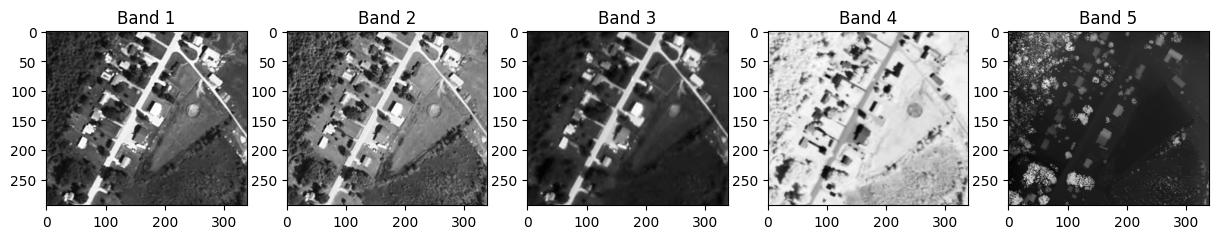

In [68]:

# Visualize each band separately
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed

# Plot each band
for i in range(stacked.shape[-1]):
    plt.subplot(1, stacked.shape[-1], i + 1)
    plt.imshow(stacked[:, :, i], cmap='gray')
    plt.title(f'Band {i+1}')

plt.show()


In [121]:
# scale image values from 0.0 - 1.0
#img = exposure.rescale_intensity(stacked)

# do segmentation multiple options with quickshift
seg_start = time.time()

#PARAMETERS:
#ratio: higher value for ratio allows more weight on the color similarity, while a lower value gives more importance to the spatial proximity
#max_dist: scale

segments = quickshift(stacked, ratio=0.2, max_dist=5.5, convert2lab=False)


print('segments complete', time.time() - seg_start)

# save segments to raster
segments_fn = 'Outputs/segments.tif'
segments_ds = driverTiff.Create(segments_fn, sat_src.width, sat_src.height, 1, gdal.GDT_Float32)
geotransform = sat_src.transform.to_gdal()
segments_ds.SetGeoTransform(geotransform)
segments_ds.SetProjection(sat_src.crs.wkt)
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None

segments complete 1.8140387535095215


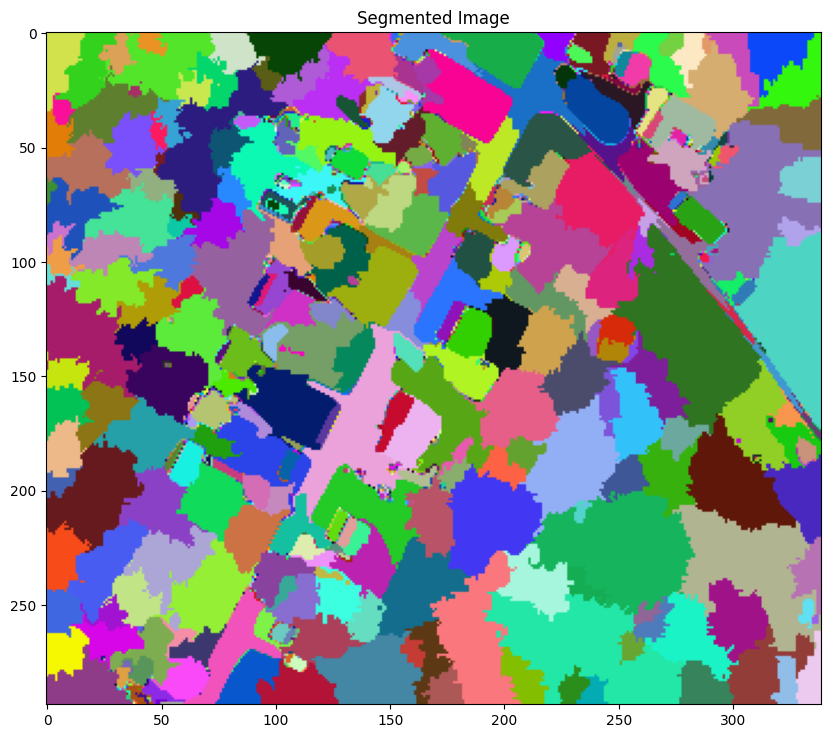

In [122]:
# Get the unique segment IDs
unique_segments = np.unique(segments)

# Create a random colormap for visualization
np.random.seed(42)  # For reproducibility of colors
colors = np.random.randint(0, 255, size=(len(unique_segments), 3), dtype=np.uint8)

# Create a colormap dictionary mapping segment IDs to colors
colormap = {segment_id: color for segment_id, color in zip(unique_segments, colors)}

# Create an empty array to hold the colored segments
colored_segments = np.zeros(segments.shape + (3,), dtype=np.uint8)

# Color the segments based on the colormap
for segment_id in unique_segments:
    colored_segments[segments == segment_id] = colormap[segment_id]

# Display the segmented image
plt.figure(figsize=(10, 10))
plt.imshow(colored_segments)
plt.title('Segmented Image')
plt.show()

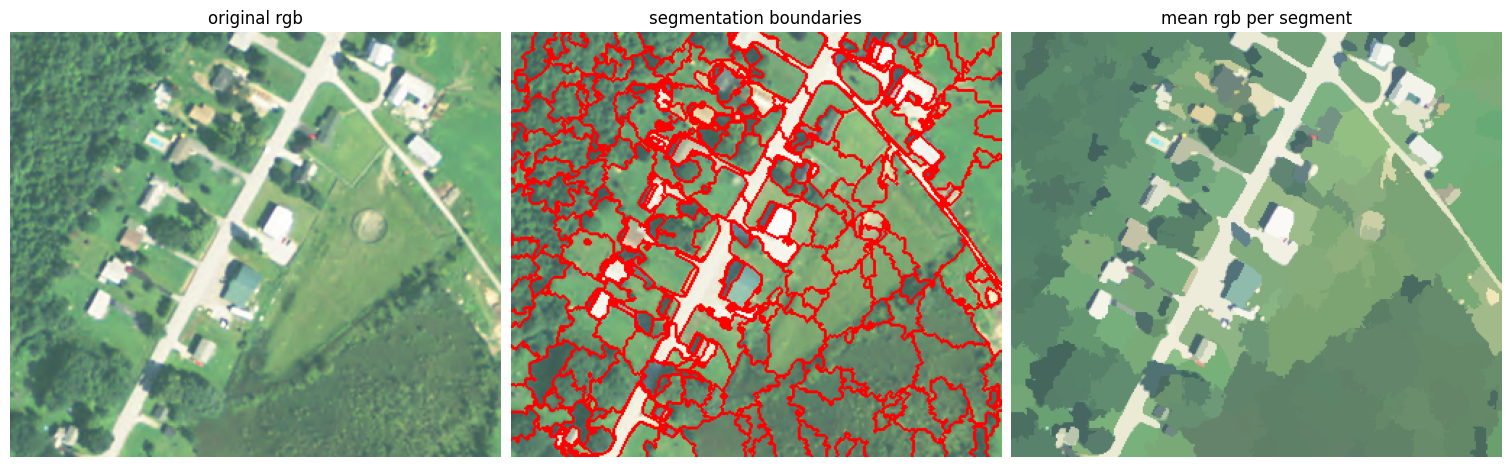

In [123]:
# visualise rgb & segmentation
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Show the RGB image
axs[0].imshow(rgb)
axs[1].imshow(mark_boundaries(rgb, segments, (1, 0, 0), mode="thick"))
axs[2].imshow(label2rgb(segments, rgb, kind='avg').astype(int))

axs[0].set_title("original rgb")
axs[1].set_title("segmentation boundaries")
axs[2].set_title("mean rgb per segment")

for ax in axs:
    ax.set_axis_off()

plt.show()

In [124]:
# Convert the segments array to integer data type
segments = segments.astype(int)

# define mean calculation function
def calc_mean(seg_arr, img_arr):
    spec_feats = regionprops_table(
        label_image = seg_arr, 
        intensity_image = img_arr,
        properties = ["label", "intensity_mean"]
        )
    return pd.DataFrame(spec_feats)  

# perform calculation & get timing
means = calc_mean(segments, np.dstack([rgb, ndvi, dsm_arr]))
display(means)

,label,intensity_mean-0,intensity_mean-1,intensity_mean-2,intensity_mean-3,intensity_mean-4
0,1,149.000000,173.000000,182.000000,-0.307018,67.000000
1,2,181.000000,210.000000,211.000000,-0.302158,67.000000
2,3,74.000000,100.000000,104.000000,0.339286,74.000000
3,4,168.000000,189.000000,176.000000,-0.312500,67.000000
4,5,69.363640,99.181816,114.272728,0.050855,67.000000
...,...,...,...,...,...,...
1279,1280,70.500000,107.500000,103.000000,0.208187,65.000000
1280,1281,145.000000,166.000000,129.333328,-0.184714,65.000000
1281,1282,182.714279,197.428574,146.428574,0.002734,65.571426
1282,1283,73.000000,111.000000,103.000000,0.353982,65.000000


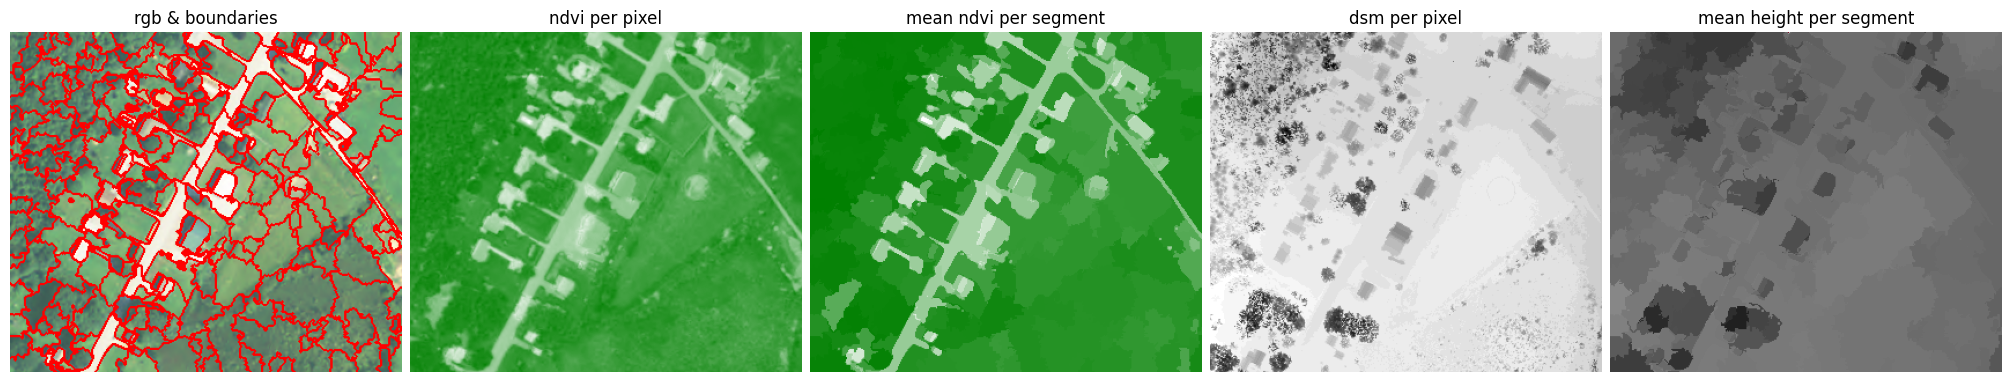

In [125]:
# mapping NDVI vals back to image segments
mapped_meanNDVI = map_array(
    segments, 
    np.array(means["label"]), 
    np.array(means["intensity_mean-3"])
    )

# mapping DSM vals back to image segments
mapped_meanDSM = map_array(
    segments, 
    np.array(means["label"]), 
    np.array(means["intensity_mean-4"])
    )

# Define the custom colormap with green for high NDVI values and grey for low NDVI values
colors = [(0.0, 'white'), (1.0, 'green')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# visualise
fig, axs = plt.subplots(ncols=5, figsize=(20,10), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[1].imshow(ndvi, cmap=custom_cmap)
axs[2].imshow(mapped_meanNDVI, cmap=custom_cmap)  # Use the custom colormap here
axs[3].imshow(dsm_arr, cmap="binary")
axs[4].imshow(mapped_meanDSM, cmap="RdGy")

axs[0].set_title("rgb & boundaries")
axs[1].set_title("ndvi per pixel")
axs[2].set_title("mean ndvi per segment")
axs[3].set_title("dsm per pixel")
axs[4].set_title("mean height per segment")

for ax in axs.flat:
    ax.set_axis_off()

plt.show()

In [126]:
#CLASSIFYING SEGMENTS

# Define the thresholds for NDVI and DSM mean values to classify segments
ndvi_threshold = 0.05
dsm_veg_threshold = 67
dsm_build_threshold = 67.5

# Add a new column 'class' to the means DataFrame and initialize it with None
# 0=unclassified, 1=low vegetation, 2=high vegetation, 3=roads, 4=buildings
means['class'] = 0

# Classify segments based on NDVI and DSM mean values
means.loc[(means['intensity_mean-3'] > ndvi_threshold) & (means['intensity_mean-4'] <= dsm_veg_threshold), 'class'] = 1
means.loc[(means['intensity_mean-3'] > ndvi_threshold) & (means['intensity_mean-4'] >= dsm_veg_threshold), 'class'] = 2
means.loc[(means['intensity_mean-3'] < ndvi_threshold) & (means['intensity_mean-4'] <= dsm_build_threshold), 'class'] = 3
means.loc[(means['intensity_mean-3'] < ndvi_threshold) & (means['intensity_mean-4'] >= dsm_build_threshold), 'class'] = 4


display(means)



,label,intensity_mean-0,intensity_mean-1,intensity_mean-2,intensity_mean-3,intensity_mean-4,class
0,1,149.000000,173.000000,182.000000,-0.307018,67.000000,3
1,2,181.000000,210.000000,211.000000,-0.302158,67.000000,3
2,3,74.000000,100.000000,104.000000,0.339286,74.000000,2
3,4,168.000000,189.000000,176.000000,-0.312500,67.000000,3
4,5,69.363640,99.181816,114.272728,0.050855,67.000000,2
...,...,...,...,...,...,...,...
1279,1280,70.500000,107.500000,103.000000,0.208187,65.000000,1
1280,1281,145.000000,166.000000,129.333328,-0.184714,65.000000,3
1281,1282,182.714279,197.428574,146.428574,0.002734,65.571426,3
1282,1283,73.000000,111.000000,103.000000,0.353982,65.000000,1


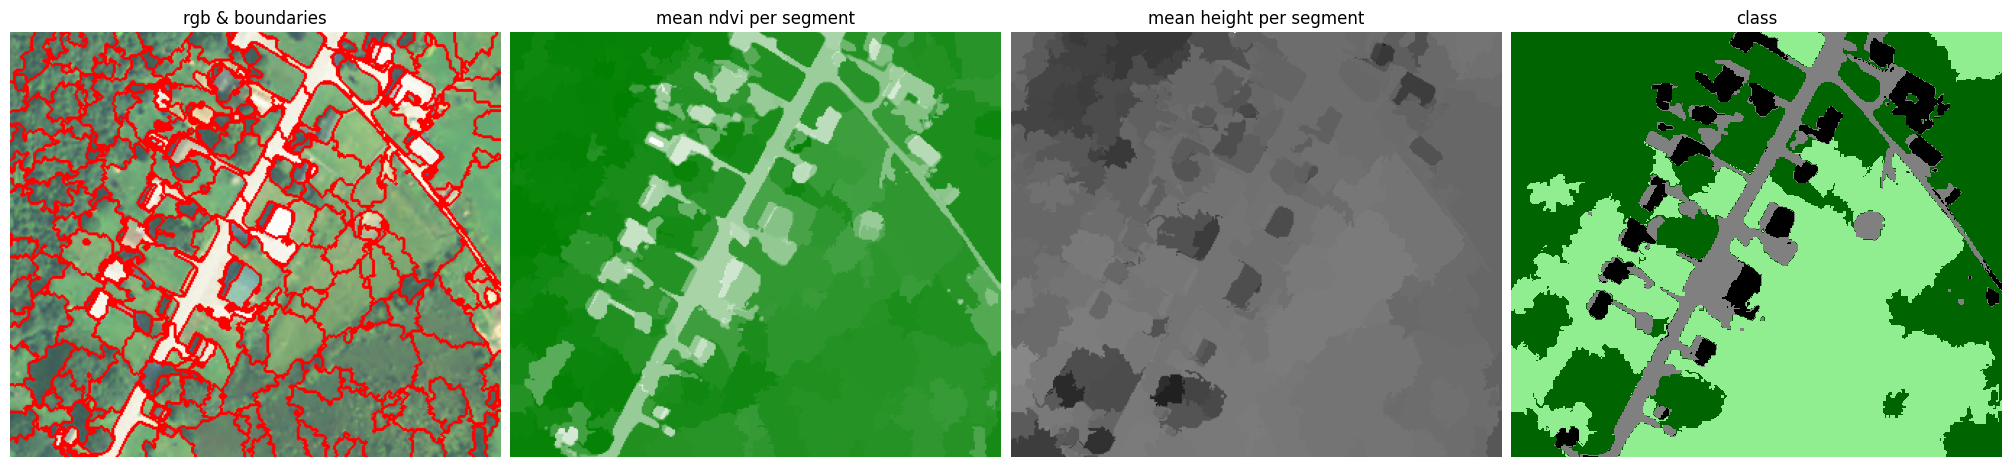

In [127]:
# mapping class vals back to image segments
mapped_class = map_array(
    segments, 
    np.array(means["label"]),
    np.array(means["class"]) 
    )


# Define the colors for each class label (0 to 4)
class_colors = ['white', 'lightgreen', 'darkgreen', 'gray', 'black']

# Create the custom colormap
class_cmap = mcolors.ListedColormap(class_colors)


# Visualize
fig, axs = plt.subplots(ncols=4, figsize=(20, 10), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1, 0, 0), mode="thick"))
axs[1].imshow(mapped_meanNDVI, cmap=custom_cmap)  # Use the custom colormap here
axs[2].imshow(mapped_meanDSM, cmap="RdGy")
axs[3].imshow(mapped_class, cmap=class_cmap)  # Use a valid colormap name here

axs[0].set_title("rgb & boundaries")
axs[1].set_title("mean ndvi per segment")
axs[2].set_title("mean height per segment")
axs[3].set_title("class")

for ax in axs.flat:
    ax.set_axis_off()

plt.show()

In [128]:
# Define a dictionary that maps class numbers to text labels
class_labels = {
    0: 'unclassified',
    1: 'low vegetation',
    2: 'trees',
    3: 'roads',
    4: 'buildings'
}

# Read the segmented image
with rio.open(segments_fn) as src:
    segments = src.read(1)

# Convert the segments to vector shapes
shapes = features.shapes(segments, transform=src.transform)

# Create a list to store the features
features_list = []

# Iterate through the shapes and add class information with text labels
for segment_id, seg_val in shapes:
    if seg_val != 0:  # Skip segments with value 0 (background)
        # Get the class value for the segment from the dataframe
        class_val = means.loc[means['label'] == int(seg_val), 'class'].values[0]
        class_label = class_labels[class_val]
        
        # Create a dictionary with the required properties
        properties = {'class': class_label}
        
        # Create a GeoJSON feature and add it to the list
        feature = {
            'type': 'Feature',
            'geometry': shape(segment_id),
            'properties': properties
        }
        
        features_list.append(feature)

# Create a GeoDataFrame from the features list
gdf = gpd.GeoDataFrame.from_features(features_list)

# Save the GeoDataFrame to a GeoJSON file
output_geojson_file = 'Outputs/segments_with_class.geojson'
gdf.to_file(output_geojson_file, driver='GeoJSON')